# Sprint データセット作成

## 1.このSprintについて

### Sprintの目的
- データセットを作成し学習する
- データ拡張を行う

### どのように学ぶか
自作のデータセットを作り、さらにデータ拡張も行なっていきます。

## 2.自作データセットの学習

自作のデータセットに対して分類および物体検出を行っていきます。具体的なタスクは講師からの指示に従ってください。



## 【準備】


In [1]:
pip install albumentations==0.4.5

In [2]:
import os
import glob
import re
import multiprocessing
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

import albumentations as albu
from albumentations.pytorch import ToTensor
from PIL import Image
import cv2


# TensorFlow Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.datasets import mnist
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls "/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/"

1_inu01.jpg  1_inu03.jpg  1_inu05.jpg   2_neko02.jpg  2_neko04.jpg
1_inu02.jpg  1_inu04.jpg  2_neko01.jpg  2_neko03.jpg  2_neko05.jpg


### 共通処理の関数の用意

In [ ]:
# モデル生成
def base_model():
    K.clear_session()
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal', bias_initializer='zeros'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
# グラフ表示
def glaph(hist):
    fig = plt.figure(figsize=(12,3.5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.plot(hist.history['loss'], label='train')
    ax1.plot(hist.history['val_loss'], label='val')
    ax1.set_title('loss')
    ax1.grid(True)
    ax1.legend(loc='best')

    ax2.plot(hist.history['accuracy'], label='train')
    ax2.plot(hist.history['val_accuracy'], label='val')
    ax2.set_title('accuracy')
    ax2.grid(True)
    ax2.legend(loc='best')
    plt.show()

## 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [ ]:
PATH = "/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/"
TRAIN_PATH = os.path.join(PATH + 'train')
TEST_PATH = os.path.join(PATH + 'test')

NUM_CPU : 4


In [ ]:
# 画像データのリストを作成
img_list = glob.glob(TRAIN_PATH + '/*' + '.jpg')
img_list

['/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu01.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu02.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu03.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu04.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu05.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/2_neko01.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/2_neko02.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/2_neko03.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/2_neko04.jpg',
 '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/2_neko05.jpg']

In [ ]:
# データフレームの作成
df = pd.DataFrame(img_list, columns=['img'])
df['class'] = df['img'].apply(lambda x: 0 if re.search('1_inu', x) else 1)
df

,img,class
0,/content/drive/My Drive/Colab Notebooks/dive_i...,0
1,/content/drive/My Drive/Colab Notebooks/dive_i...,0
2,/content/drive/My Drive/Colab Notebooks/dive_i...,0
3,/content/drive/My Drive/Colab Notebooks/dive_i...,0
4,/content/drive/My Drive/Colab Notebooks/dive_i...,0
5,/content/drive/My Drive/Colab Notebooks/dive_i...,1
6,/content/drive/My Drive/Colab Notebooks/dive_i...,1
7,/content/drive/My Drive/Colab Notebooks/dive_i...,1
8,/content/drive/My Drive/Colab Notebooks/dive_i...,1
9,/content/drive/My Drive/Colab Notebooks/dive_i...,1


In [ ]:
# split
X_train, X_val, y_train, y_val = train_test_split(df['img'], df['class'], test_size=TEST_SIZE)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7,), (7,), (3,), (3,))

In [ ]:
# test
test_img_list = glob.glob(TEST_PATH + '/*.jpg')
df_test = pd.DataFrame(test_img_list, columns=['img'])
df_test['class'] = df_test['img'].apply(lambda x: 0 if re.search('dog_', x) else 1)
df_test

,img,class
0,/content/drive/My Drive/Colab Notebooks/dive_i...,0
1,/content/drive/My Drive/Colab Notebooks/dive_i...,1
2,/content/drive/My Drive/Colab Notebooks/dive_i...,0
3,/content/drive/My Drive/Colab Notebooks/dive_i...,1
4,/content/drive/My Drive/Colab Notebooks/dive_i...,1
5,/content/drive/My Drive/Colab Notebooks/dive_i...,0
6,/content/drive/My Drive/Colab Notebooks/dive_i...,1


(10, 224, 224, 3)
float32


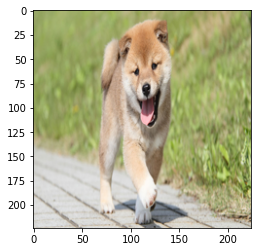

In [ ]:
def simple_transform(img_list):
    img_array = np.empty((0,224,224,3))
    for path in img_list:
        with Image.open(path) as img:
            img = img.resize((224, 224)).convert('RGB')
            img = np.array(img) / 255.
            img = img.reshape((1, 224, 224, 3))
            img_array = np.concatenate([img_array, img], axis=0)
    return img_array.astype('float32')

img_array = simple_transform(df['img'])
test_img_array = simple_transform(df_test['img'])

print(img_array.shape)
print(img_array.dtype)

plt.imshow(img_array[0])
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 512)     1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 1024)      4719616   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 1024)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0

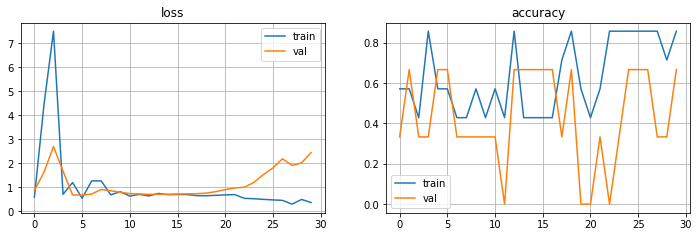

In [ ]:
model = base_model()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
history = model.fit(img_array[:7],
                    y_train,
                    epochs=30,
                    batch_size=5,
                    shuffle=True,
                    validation_data=(img_array[7:], y_val))

glaph(history)

### Kerasでの読み込み

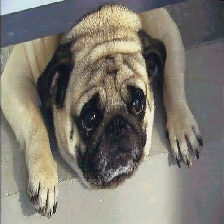

In [ ]:
img_keras = load_img(img_list[4], grayscale=False, color_mode='rgb', target_size=(224, 224))
img_keras

## 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。


《データ拡張のためのライブラリ》


データ拡張にはalbumentationsなどがあります。

<a href="https://github.com/albumentations-team/albumentations">
albu/albumentations: fast image augmentation library and easy to use wrapper around other libraries
</a>


また、Kerasを使う場合はImageDataGeneratorも便利です。




《データ拡張の効果の調査》


データ拡張には様々な方法があります。今回のタスクにおいて各手法がどう効果があるかを実験・考察してください。

In [ ]:
transform_train = albu.Compose([
                albu.RandomRotate90(),
                albu.Flip(),
                albu.Transpose(),
                albu.OneOf([
                    albu.IAAAdditiveGaussianNoise(),
                    albu.GaussNoise(),
                ], p=0.2),
                albu.OneOf([
                    albu.MotionBlur(p=.2),
                    albu.MedianBlur(blur_limit=3, p=0.1),
                    albu.Blur(blur_limit=3, p=0.1),
                ], p=0.2),
                albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                albu.OneOf([
                    albu.OpticalDistortion(p=0.3),
                    albu.GridDistortion(p=.1),
                    albu.IAAPiecewiseAffine(p=0.3),
                ], p=0.2),
                albu.OneOf([
                    albu.CLAHE(clip_limit=2),
                    albu.IAASharpen(),
                    albu.IAAEmboss(),
                    albu.RandomBrightnessContrast(),            
                ], p=0.3),
                albu.HueSaturationValue(p=0.3),
                albu.Resize(224, 224),
                albu.Normalize()
            ])

transform_valid = albu.Compose([
                albu.Resize(224, 224),
                albu.Normalize()
            ])

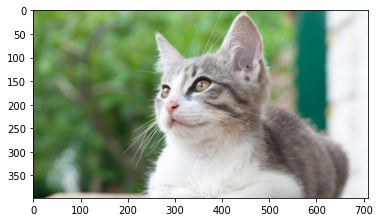

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


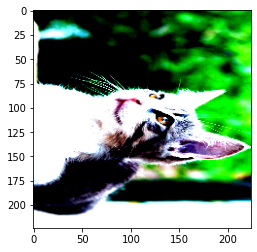

In [ ]:
# transformの確認
image = cv2.imread(img_list[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

test_img = transform_train(image=image)['image']
plt.imshow(test_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 224, 224, 3)
float32


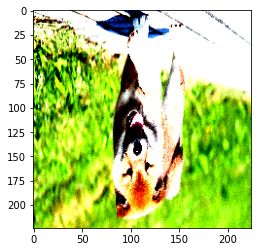

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


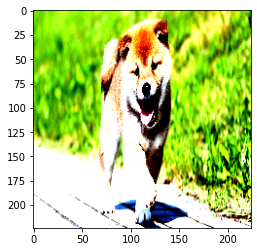

In [ ]:
def my_transform(img_list, transformer=None):
    img_array = np.empty((0,224,224,3))
    for path in img_list:

        if transformer != None:
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = transformer(image=image)['image']
            image = np.array(image)
            image = image.reshape((1, 224, 224, 3))
            img_array = np.concatenate([img_array, image], axis=0)
    return img_array.astype('float32')


X_train_albu = my_transform(df['img'], transform_train)
test_img_albu = my_transform(df_test['img'], transform_valid)

print(X_train_albu.shape)
print(X_train_albu.dtype)

plt.imshow(X_train_albu[0])
plt.show()

plt.imshow(X_val_albu[2])
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 512)     1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 1024)      4719616   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 1024)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0

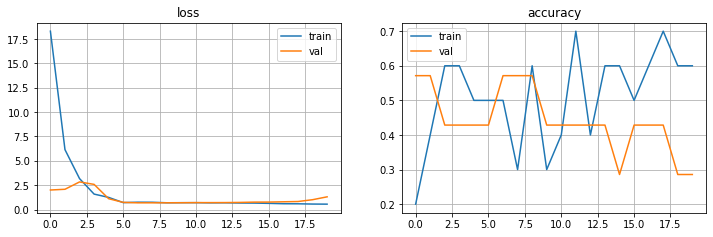

In [ ]:
model = base_model()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
history = model.fit(X_train_albu,
                    df['class'],
                    epochs=20,
                    batch_size=5,
                    shuffle=True,
                    validation_data=(test_img_albu, df_test['class']))

glaph(history)

## 【問題3】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。


《アノテーションのためのツール》


アノテーションツールにはLabelImgなどがあります。

<a href="https://github.com/tzutalin/labelImg">
tzutalin/labelImg: LabelImg is a graphical image annotation tool and label object bounding boxes in images
</a>



In [55]:
!ls -l '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train_xml/'
!cat '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train_xml/2_neko04.xml' | grep -v '<path>'

total 10
-rw------- 1 root root 577 Sep 29 13:01 1_inu01.xml
-rw------- 1 root root 572 Sep 29 13:02 1_inu02.xml
-rw------- 1 root root 577 Sep 29 13:02 1_inu03.xml
-rw------- 1 root root 576 Sep 29 13:02 1_inu04.xml
-rw------- 1 root root 575 Sep 29 13:03 1_inu05.xml
-rw------- 1 root root 577 Sep 29 13:03 2_neko01.xml
-rw------- 1 root root 580 Sep 29 13:03 2_neko02.xml
-rw------- 1 root root 578 Sep 29 13:04 2_neko03.xml
-rw------- 1 root root 578 Sep 29 13:04 2_neko04.xml
-rw------- 1 root root 807 Sep 29 13:05 2_neko05.xml
<annotation>
	<folder>train_anno</folder>
	<filename>2_neko04.jpg</filename>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>300</width>
		<height>225</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>cat</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>106</xmin>
			<ymin>14</ymin>
			<xmax>204</xmax>
			<ymax>123</ymax>
		</bndbox>
	</object>
</annota

## 【問題4】物体検出データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。詳細はREADME.mdを確認してください。


物体検出の学習を行なうかどうかは任意とします。

In [19]:
# image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu03.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.show()
# del image

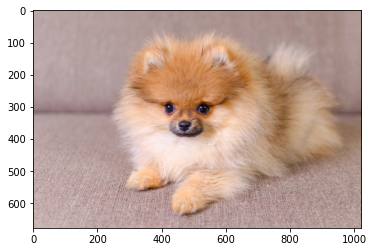

(678, 1024, 3)


In [20]:
with Image.open('/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train/1_inu03.jpg') as img:
    image = np.array(img)
    plt.imshow(img)
    plt.show()
print(image.shape)

In [21]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [22]:
XML_PATH = '/content/drive/My Drive/Colab Notebooks/dive_into_code/Sprint18/img/train_xml/'
def get_xml_elem(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    for child in root:
        if child.tag == 'object':
            x_min = int(child[4][0].text)
            y_min = int(child[4][1].text)
            x_max = int(child[4][2].text)
            y_max = int(child[4][3].text)
            w = x_max - x_min
            h = y_max - y_min
    return x_min, y_min, w, h

def get_bboxes(dir):
    file_list = glob.glob(dir + '*.xml')
    bboxes = []
    for fname in file_list:
        bboxes.append(get_xml_elem(fname))
    return bboxes

# テスト
print(get_xml_elem(os.path.join(XML_PATH, '2_neko04.xml')))
print(get_bboxes(XML_PATH))

(106, 14, 98, 109)
[(362, 18, 405, 601), (162, 28, 292, 306), (264, 49, 433, 541), (237, 49, 153, 329), (101, 8, 283, 230), (253, 9, 256, 389), (284, 96, 855, 464), (212, 10, 242, 358), (106, 14, 98, 109), (914, 454, 612, 416)]


In [23]:
bboxes = [get_xml_elem(os.path.join(XML_PATH, '1_inu03.xml'))]
print(bboxes)
category_ids = [18]
category_id_to_name = {17: 'cat', 18: 'dog'}

[(264, 49, 433, 541)]


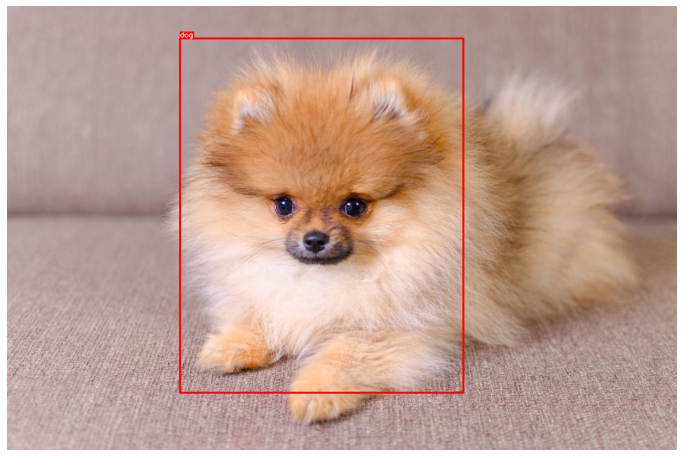

In [24]:
visualize(image, bboxes, category_ids, category_id_to_name)

In [25]:
# transform = albu.Compose(
#     [albu.HorizontalFlip(p=0.5)],
#     bbox_params=albu.BboxParams(format='coco', label_fields=['category_ids']),
# )

In [28]:
transform = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(p=0.5),
        albu.RandomBrightnessContrast(p=0.3),
        albu.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=albu.BboxParams(format='coco', label_fields=['category_ids']),
)

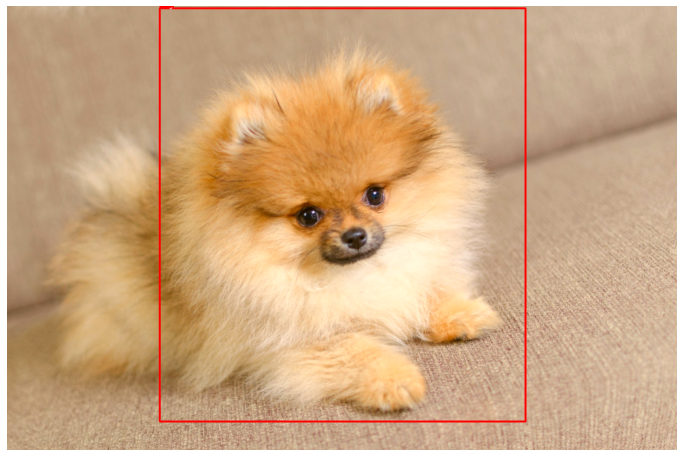

In [33]:
# random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)